In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score)
import lightgbm as lgb
import time
import os
import kagglehub
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("Step 1: Loading and preparing data...")

path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print(f"Dataset downloaded to: {path}")

csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if csv_files:
    main_file = csv_files[0]
    file_path = os.path.join(path, main_file)
    print(f"\nLoading main dataset file: {main_file}")

    df = pd.read_csv(file_path)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Remove customerID (not useful for modeling)
df = df.drop('customerID', axis=1)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Step 1: Loading and preparing data...
Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Dataset downloaded to: /kaggle/input/telco-customer-churn

Loading main dataset file: WA_Fn-UseC_-Telco-Customer-Churn.csv
Dataset shape: (7043, 20)
Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [3]:
print("\nStep 2: Feature engineering...")

df['Tenure_Group'] = pd.cut(df['tenure'],
                           bins=[0, 12, 24, 36, 60, 100],
                           labels=['0-1yr', '1-2yr', '2-3yr', '3-5yr', '5+yr'])

df['MonthlyCharge_Group'] = pd.cut(df['MonthlyCharges'],
                                  bins=[0, 35, 70, 100, 200],
                                  labels=['Low', 'Medium', 'High', 'Very High'])

services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
           'TechSupport', 'StreamingTV', 'StreamingMovies']
df['Total_Services'] = df[services].apply(lambda x: (x == 'Yes').sum(), axis=1)

print("Created new features: Tenure_Group, MonthlyCharge_Group, Total_Services")


Step 2: Feature engineering...
Created new features: Tenure_Group, MonthlyCharge_Group, Total_Services


In [4]:
print("\nStep 3: Data preprocessing...")

feature_columns = [
    'tenure', 'MonthlyCharges', 'TotalCharges', 'Total_Services',
    'SeniorCitizen', 'Contract', 'InternetService', 'PaymentMethod',
    'PaperlessBilling', 'Tenure_Group', 'MonthlyCharge_Group'
]

# Feature matrix
X = df[feature_columns]
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Handle categorical variables
categorical_columns = ['Contract', 'InternetService', 'PaymentMethod',
                      'PaperlessBilling', 'Tenure_Group', 'MonthlyCharge_Group']

X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

print(f"Final feature matrix: {X_encoded.shape}")


Step 3: Data preprocessing...
Final feature matrix: (7043, 20)


In [5]:
print("\nStep 4: Train-test split...")

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,test_size=0.2,random_state=42,stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Churn rate in training: {y_train.mean():.2%}")
print(f"Churn rate in test: {y_test.mean():.2%}")


Step 4: Train-test split...
Training set: 5634 samples
Test set: 1409 samples
Churn rate in training: 26.54%
Churn rate in test: 26.54%


In [6]:
# =============================================
# LIGHTGBM MODEL
# =============================================

print("\nStep 5: Training baseline LightGBM model...")

lgb_baseline = lgb.LGBMClassifier(
    random_state=42, n_jobs=-1, verbose=-1)

lgb_baseline.fit(X_train, y_train)

# Make predictions
y_pred_baseline = lgb_baseline.predict(X_test)
y_pred_proba_baseline = lgb_baseline.predict_proba(X_test)[:, 1]

# Evaluate baseline
baseline_auc = roc_auc_score(y_test, y_pred_proba_baseline)
baseline_accuracy = (y_pred_baseline == y_test).mean()

print(f"✅ Baseline Model Performance:")
print(f"   ROC-AUC: {baseline_auc:.4f}")
print(f"   Accuracy: {baseline_accuracy:.4f}")

print("\n🎛️  Step 6: Hyperparameter tuning...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create and train with grid search
lgb_tuned = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

print("Performing grid search (this may take a few minutes)...")
grid_search = GridSearchCV(
    estimator=lgb_tuned,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

print("Hyperparameter tuning completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")


Step 5: Training baseline LightGBM model...
✅ Baseline Model Performance:
   ROC-AUC: 0.8360
   Accuracy: 0.7913

🎛️  Step 6: Hyperparameter tuning...
Performing grid search (this may take a few minutes)...
Hyperparameter tuning completed!
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}
Best CV score: 0.8452


In [7]:
# =============================================
# FINAL MODEL TRAINING
# =============================================

print("\nStep 7: Training final model with best parameters...")

# Train final model with best parameters
final_model = grid_search.best_estimator_

# Make predictions with final model
y_pred_final = final_model.predict(X_test)
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]


Step 7: Training final model with best parameters...


FINAL MODEL PERFORMANCE:
ROC-AUC: 0.8417
Accuracy: 0.7984

Improvement over baseline:
   ROC-AUC: +0.0057
   Accuracy: +0.0071

Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.91      0.87      1035
       Churn       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



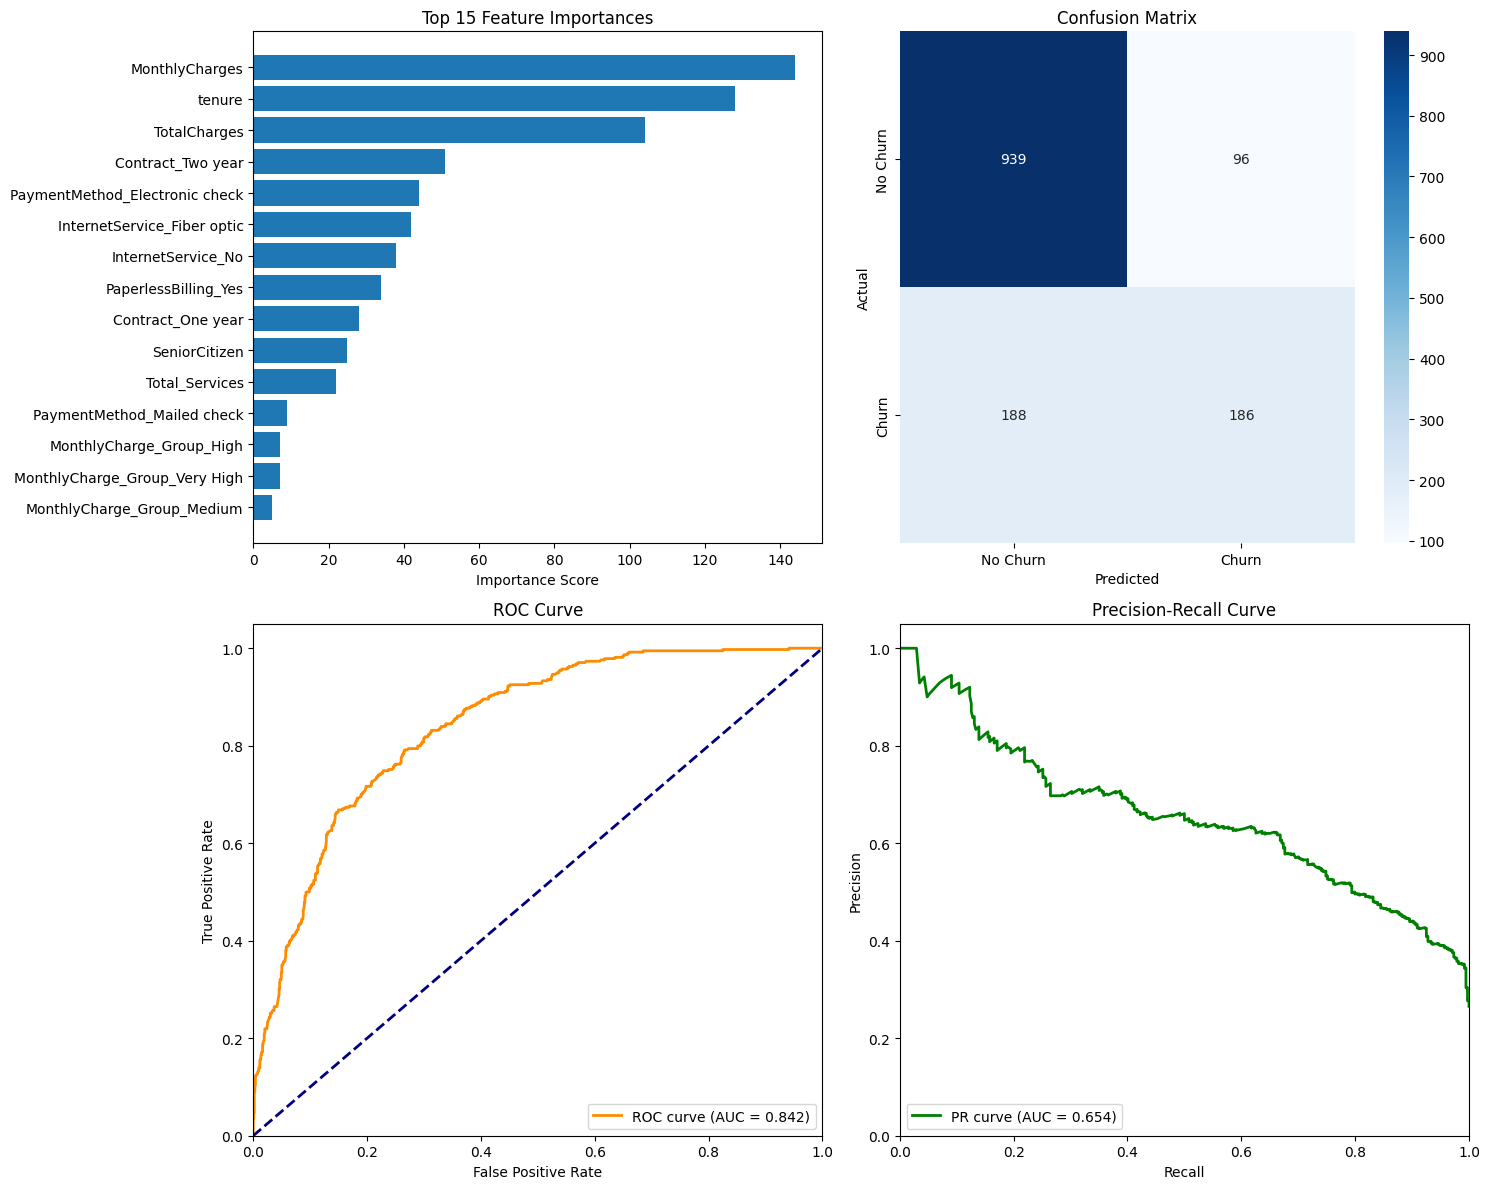


MODEL READINESS FOR DEPLOYMENT:
 ROC-AUC Score: 0.8417 (Good: >0.8, Excellent: >0.9)
 Accuracy: 0.7984
 Features Used: 20

TOP 5 CHURN DRIVERS:
   • MonthlyCharges: 144.0
   • tenure: 128.0
   • TotalCharges: 104.0
   • Contract_Two year: 51.0
   • PaymentMethod_Electronic check: 44.0

CUSTOMER RISK SEGMENTATION:
   • Low Risk: 4297 customers (61.0%)
   • Medium Risk: 2343 customers (33.3%)
   • High Risk: 403 customers (5.7%)

HIGH-RISK CUSTOMER PROFILE:
   • Average tenure: 3.0 months
   • Average monthly charges: $83.85
   • Most common contract: Month-to-month

Model saved as 'telco_churn_lgb_model.pkl'

MODEL TRAINING COMPLETE!

PERFORMANCE SUMMARY:
   • Final ROC-AUC: 0.8417
   • Final Accuracy: 0.7984
   • Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}




In [11]:
# =============================================
# MODEL EVALUATION
# =============================================

# Metrics
final_auc = roc_auc_score(y_test, y_pred_proba_final)
final_accuracy = (y_pred_final == y_test).mean()

print(f"FINAL MODEL PERFORMANCE:")
print(f"ROC-AUC: {final_auc:.4f}")
print(f"Accuracy: {final_accuracy:.4f}")

print(f"\nImprovement over baseline:")
print(f"   ROC-AUC: +{(final_auc - baseline_auc):.4f}")
print(f"   Accuracy: +{(final_accuracy - baseline_accuracy):.4f}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['No Churn', 'Churn']))

# =============================================
# VISUALIZATIONS
# =============================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=True).tail(15)

axes[0,0].barh(feature_importance['feature'], feature_importance['importance'])
axes[0,0].set_title('Top 15 Feature Importances')
axes[0,0].set_xlabel('Importance Score')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0,1].set_title('Confusion Matrix')
axes[0,1].set_ylabel('Actual')
axes[0,1].set_xlabel('Predicted')

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2,
               label=f'ROC curve (AUC = {final_auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_final)
pr_auc = auc(recall, precision)
axes[1,1].plot(recall, precision, color='green', lw=2,
               label=f'PR curve (AUC = {pr_auc:.3f})')
axes[1,1].set_xlim([0.0, 1.0])
axes[1,1].set_ylim([0.0, 1.05])
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Curve')
axes[1,1].legend(loc="lower left")

plt.tight_layout()
plt.show()

# =============================================
# BUSINESS INTERPRETATION
# =============================================

print(f"\nMODEL READINESS FOR DEPLOYMENT:")
print(f" ROC-AUC Score: {final_auc:.4f} ")
print(f" Accuracy: {final_accuracy:.4f}")
print(f" Features Used: {X_encoded.shape[1]}")

print(f"\nTOP 5 CHURN DRIVERS:")
top_features = feature_importance.sort_values('importance', ascending=False).head(5)
for idx, row in top_features.iterrows():
    print(f"   • {row['feature']}: {row['importance']:.1f}")

# Predict churn probability for all customers
df['Churn_Probability'] = final_model.predict_proba(X_encoded)[:, 1]

# Segment customers by churn risk
def risk_segment(prob):
    if prob < 0.3:
        return 'Low Risk'
    elif prob < 0.7:
        return 'Medium Risk'
    else:
        return 'High Risk'

df['Churn_Risk'] = df['Churn_Probability'].apply(risk_segment)

print(f"\nCUSTOMER RISK SEGMENTATION:")
risk_counts = df['Churn_Risk'].value_counts()
for risk, count in risk_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   • {risk}: {count} customers ({percentage:.1f}%)")

# High-risk customer analysis
high_risk_customers = df[df['Churn_Risk'] == 'High Risk']
if len(high_risk_customers) > 0:
    print(f"\nHIGH-RISK CUSTOMER PROFILE:")
    print(f"   • Average tenure: {high_risk_customers['tenure'].mean():.1f} months")
    print(f"   • Average monthly charges: ${high_risk_customers['MonthlyCharges'].mean():.2f}")
    print(f"   • Most common contract: {high_risk_customers['Contract'].mode().iloc[0]}")

# =============================================
# MODEL SAVING
# =============================================

import joblib

# Save model and preprocessing artifacts
model_artifacts = {
    'model': final_model,
    'feature_names': X_encoded.columns.tolist(),
    'categorical_columns': categorical_columns,
    'feature_importance': feature_importance
}

joblib.dump(model_artifacts, 'telco_churn_lgb_model.pkl')
print("\nModel saved as 'telco_churn_lgb_model.pkl'")

# =============================================
# SUMMARY
# =============================================

print("\n" + "="*50)
print("MODEL TRAINING COMPLETE!")
print("="*50)

print(f"""
PERFORMANCE SUMMARY:
   • Final ROC-AUC: {final_auc:.4f}
   • Final Accuracy: {final_accuracy:.4f}
   • Best Parameters: {grid_search.best_params_}

""")